In [1]:
# Utility imports
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import pykep as pk
import MSMatch as mm
import matplotlib.pyplot as plt
import numpy as np

/home/pablo/anaconda3/envs/distmsmatch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [5]:
cfg=mm.load_cfg(None)
cfg.nodes = 8
# get constellations params
# PASEOS setup
altitude = 786 * 1000  # altitude above the Earth's ground [m]
inclination = 98.62  # inclination of the orbit
nPlanes = 1 # the number of orbital planes (see linked wiki article)
nSats = cfg.nodes # the number of satellites per orbital plane
t0 = pk.epoch_from_string("2023-Dec-17 14:42:42")  # starting date of our simulation

# Compute orbits of LEO satellites
planet_list,sats_pos_and_v = mm.get_constellation(altitude,inclination,nSats,nPlanes,t0)

Using default configuration...
dataset                     : eurosat_rgb    |net                         : efficientnet-lite0|batch_size                  : 32             |
p_cutoff                    : 0.95           |lr                          : 0.03           |uratio                      : 7              |
weight_decay                : 0.00075        |ulb_loss_ratio              : 1.0            |seed                        : 42             |
num_labels                  : 1000           |opt                         : SGD            |pretrained                  : 0              |
save_dir                    : ./results/     |ema_m                       : 0.99           |bn_momentum                 : 0.01           |
eval_batch_size             : 1024           |momentum                    : 0.9            |T                           : 0.5            |
amp                         : 0              |hard_label                  : 1              |num_eval_iter               : 100       

In [6]:
logger_level = "INFO"
logger = mm.get_logger(cfg.save_path, logger_level)

In [7]:
nodes,actors = [],[]
for rank in range(cfg.nodes):
    node = mm.PaseosNode(rank, sats_pos_and_v[rank], cfg, None, logger)
    nodes.append(node)
    actors.append(node.paseos.local_actor)

In [8]:
positions = []
for actor in actors:
    positions.append(actor.get_position(t0))

In [9]:
# Ground stations
from paseos import ActorBuilder, GroundstationActor
stations = [
    ["Maspalomas", 27.7629, -15.6338, 205.1],
    ["Matera", 40.6486, 16.7046, 536.9],
    ["Svalbard", 78.9067, 11.8883, 474.0],
]
groundstation_actors = []
for station in stations:
    gs_actor = ActorBuilder.get_actor_scaffold(
        name=station[0], actor_type=GroundstationActor, epoch=t0
    )
    ActorBuilder.set_ground_station_location(
        gs_actor,
        latitude=station[1],
        longitude=station[2],
        elevation=station[3],
        minimum_altitude_angle=5,
    )
    # paseos_instance.add_known_actor(gs_actor)
    groundstation_actors.append(gs_actor)

In [96]:
tX,tY,tZ = [],[],[]
N = 600
for n in range(N):
    pos = actors[0].get_position(pk.epoch(t0.mjd2000 + pk.SEC2DAY * n * 10))
    tX.append(pos[0])
    tY.append(pos[1])
    tZ.append(pos[2])

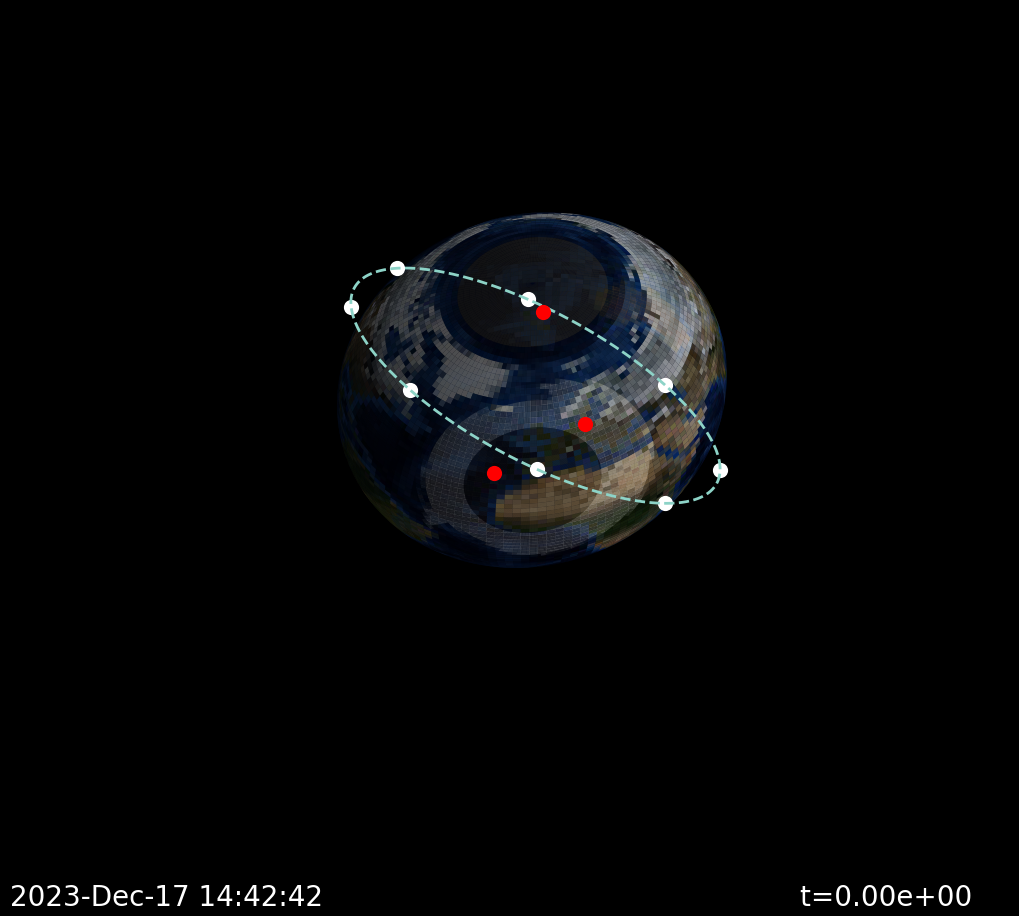

In [111]:
with plt.style.context("dark_background"):
    ax = plt.figure(figsize=(5, 5),dpi=200).add_subplot(111,projection='3d',facecolor="black",computed_zorder=False)
    ax.view_init(elev=45, azim=300)

    # Get rid of the panes
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Get rid of the spines
    ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_zaxis().set_ticks([])

    # load bluemarble with PIL
    import PIL
    R = 6371000
    bm = PIL.Image.open('blue_marble.jpg')
    # it's big, so I'll rescale it, convert to array, and divide by 256 to get RGB values that matplotlib accept 
    # bm = np.array(bm.resize([int(d) for d in bm.size]))/256.
    bm = np.array(bm) / 256

    # coordinates of the image - don't know if this is entirely accurate, but probably close
    lons = np.linspace(-180, 180, bm.shape[1]) * np.pi/180 
    lats = np.linspace(-90, 90, bm.shape[0])[::-1] * np.pi/180 

    x = np.outer(np.cos(lons+30.5), np.cos(lats)).T
    y = np.outer(np.sin(lons+30.5), np.cos(lats)).T
    z = np.outer(np.ones(np.size(lons)), np.sin(lats)).T
    ax.plot_surface(R*x, R*y, R*z, rstride=2, cstride=2, facecolors = bm,linewidth=0,alpha=0.75,zorder=0)

    for pos in positions:
        ax.scatter(pos[0],pos[1],pos[2],color="white").set_zorder(10)

    for gs in groundstation_actors:
        pos = gs.get_position(t0)
        ax.scatter(pos[0],pos[1],pos[2],color="red",zorder=20)

    ax.plot(tX,tY,tZ,zorder=10,linestyle="--",linewidth=1)

     # Write text labels
    plt.annotate(
        t0,
        xy=(0.01, 0.01),
        xycoords="figure fraction",
    )
    plt.annotate(
        f"t={nodes[0].paseos._state.time:<10.2e}",
        xy=(0.99, 0.01),
        xycoords="figure fraction",
        horizontalalignment="right",
    )

    plt.show()